In [1]:
%matplotlib inline

In [2]:
from pyesgf.logon import LogonManager
from pyesgf.search import SearchConnection
import xarray as xr

intialize the logon manager

In [3]:
lm = LogonManager()
if not lm.is_logged_on():
    lm.logon(hostname="esgf-data.dkrz.de", bootstrap=True, interactive=True)


Enter myproxy username:

 pingutest1
Enter password for pingutest1:  ···········


In [4]:
lm.is_logged_on()

True

In [5]:
def print_context_info(ctx):
    print('Hits:', ctx.hit_count)
    print('Experiments:', ctx.facet_counts['experiment'])
    print('Ensembles:', ctx.facet_counts['ensemble'])

search for some data

In [6]:
conn = SearchConnection('http://esgf-data.dkrz.de/esg-search', distrib=True)
ctx = conn.new_context(project='CORDEX', institute='MPI-CSC', experiment='historical', time_frequency='day')
ctx = ctx.constrain(ensemble='r1i1p1', variable='tasmax')


print a summary of what we found

In [7]:
print_context_info(ctx)

('Hits:', 6)
('Experiments:', {u'historical': 6})
('Ensembles:', {u'r1i1p1': 6})


aggregate results

In [8]:
result = ctx.search()[0]
agg_ctx = result.aggregation_context()


get a list of opendap urls

In [9]:
x = list(a.opendap_url for a in agg_ctx.search() if a.opendap_url)
print(x)


[u'http://esgf1.dkrz.de/thredds/dodsC/cordex.output.AFR-44.MPI-CSC.MPI-M-MPI-ESM-LR.historical.r1i1p1.REMO2009.v1.day.tasmax.tasmax.20160412.aggregation']


try opening one of the opendap datasets

In [10]:
from netCDF4 import Dataset
ds = Dataset(x[0], 'r')

In [11]:
ds.ncattrs()
ds.getncattr('experiment')


u'historical'

In [12]:
ds.variables.keys()

[u'rlat',
 u'rlon',
 u'rotated_latitude_longitude',
 u'lat_vertices',
 u'lon_vertices',
 u'height',
 u'time',
 u'time_bnds',
 u'lat',
 u'lon',
 u'tasmax']

In [13]:
ds.variables['time']

<type 'netCDF4._netCDF4.Variable'>
float64 time(time)
    bounds: time_bnds
    units: days since 1949-12-01T00:00:00Z
    calendar: proleptic_gregorian
    axis: T
    long_name: time
    standard_name: time
    _ChunkSizes: 1
unlimited dimensions: 
current shape = (20454,)
filling off

In [14]:
ds.variables['tasmax']

<type 'netCDF4._netCDF4.Variable'>
float32 tasmax(time, rlat, rlon)
    standard_name: air_temperature
    long_name: Daily Maximum Near-Surface Air Temperature
    comment: daily-maximum near-surface (usually, 2 meter) air temperature.
    units: K
    cell_methods: time: maximum
    history: 2015-07-18T13:19:05Z altered by CMOR: Treated scalar dimension: 'height'. 2015-07-18T13:19:05Z altered by CMOR: replaced missing value flag (-1e+20) with standard missing value (1e+20).
    coordinates: height lat lon
    missing_value: 1e+20
    _FillValue: 1e+20
    associated_files: gridspecFile: gridspec_atmos_fx_MPI-CSC-REMO2009_historical_r0i0p0.nc
    grid_mapping: rotated_latitude_longitude
    _ChunkSizes: [  1 201 194]
unlimited dimensions: 
current shape = (20454, 201, 194)
filling off

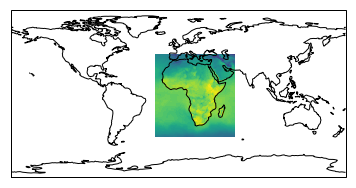

In [15]:
import matplotlib.pyplot as plt
from cartopy import config
import cartopy.crs as ccrs

timestep = 0

tasmax = ds.variables['tasmax'][timestep, :, :]
lats = ds.variables['lat'][:]
lons = ds.variables['lon'][:]

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.set_global()

fig = plt.contourf(lons, lats, tasmax, 60, transform=ccrs.PlateCarree())
#plt.show()


using pydap:

https://pydap.readthedocs.io/en/latest/client.html?highlight=esgf

In [21]:
openid='https://esgf-data.dkrz.de/esgf-idp/openid/pingutest1'
password='secret'


In [24]:
from pydap.client import open_url
from pydap.cas.esgf import setup_session
dataset_url = x[0]
session = setup_session(openid, password, check_url=dataset_url, verify=True)
dataset = open_url(dataset_url, session=session)


AttributeError: 'NoneType' object has no attribute 'select'

In [16]:
xr.open_dataset(x[0], engine='pydap')

Exception: Unable to parse token: 